# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Загружаем датасет с помощью Pandas
data = pd.read_csv('AB_NYC_2019.csv')

# Добавляем в датасет для каждого объекта расстояние до центра Манхеттена
man_lat = (data[data['neighbourhood_group'] == 'Manhattan']['latitude'].max() - data[data['neighbourhood_group'] == 'Manhattan']['latitude'].min()) / 2
man_lon = (data[data['neighbourhood_group'] == 'Manhattan']['longitude'].max() - data[data['neighbourhood_group'] == 'Manhattan']['longitude'].min()) / 2
data['man_dist'] = abs(data['latitude'] - man_lat) + abs(data['longitude'] - man_lon)

# Кодируем числами категориальные признаки room_type и neighbourhood_group
le = LabelEncoder()
data['room_type'] = le.fit_transform(data['room_type'])
data['neighbourhood'] = le.fit_transform(data['neighbourhood'])
data['neighbourhood_group'] = le.fit_transform(data['neighbourhood_group'])

# Заполняем NoN в reviews_per_month
data['reviews_per_month'] = data['reviews_per_month'].fillna(-1)

# Отрезаем лишние колонки
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude']
data = data.drop(columns=cols_to_drop)

In [210]:
c = data.groupby('neighbourhood').size()
c[c<3]

neighbourhood
9      2
42     2
82     1
100    2
114    2
141    1
165    1
172    1
177    2
208    2
211    2
215    1
219    1
dtype: int64

In [223]:
# Проставляем Категорию жилья в зависимости от ценового диапазона (с учётом района и типа жилья)
list_neighbourhood = list(data['neighbourhood'].unique())
list_room_type = list(data['room_type'].unique())

data['category'] = 0

for i in list_neighbourhood:
    for j in list_room_type:
        count = data[(data['neighbourhood'] == i) & (data['room_type'] == j)].shape[0]
        if count != 0:
            mask = (data['neighbourhood'] == i) & (data['room_type'] == j)
            mean = int(data[mask]['price'].mean())

            mask = (data['neighbourhood'] == i) & (data['room_type'] == j)
            std = data[mask]['price'].std()
            std = int(np.nan_to_num(std, nan=0))

            mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['price'] > mean + 1 * std)
            data.loc[mask, 'category'] = 1

In [224]:
# Убираем строки с отклонениями цены более 2 сигмы (с учётом района, типа и категории жилья)
list_category = list(data['category'].unique())

for i in list_neighbourhood:
    for j in list_room_type:
        for k in list_category:
            count = data[(data['neighbourhood'] == i) & (data['room_type'] == j) & (data['category'] == k)].shape[0]
            if count != 0:
                mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['category'] == k)
                mean = int(data[mask]['price'].mean())

                mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['category'] == k)
                std = data[mask]['price'].std()
                std = int(np.nan_to_num(std, nan=0))

                mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['category'] == k) & (data['price'] > mean + 1.5 * std)
                data = data.drop(data[mask].index)

                mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['category'] == k) & (data['price'] < mean - 1.5 * std)
                data = data.drop(data[mask].index)

<Axes: xlabel='category'>

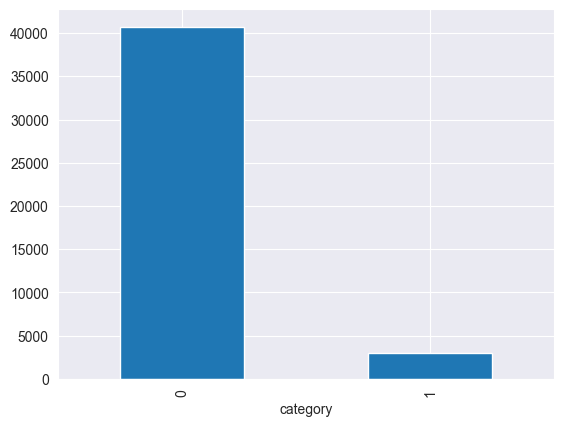

In [225]:
# Проверяем распределение целевой переменной
import matplotlib.pyplot as plt
import seaborn as sns

# data['category'].value_counts().plot.bar(figsize=(6, 4))
data['category'].value_counts().plot.bar()
# data['room_type'].value_counts().plot.bar()
# data['neighbourhood'].value_counts().plot.bar()
# plt.grid(axis='y')
# data['category'].value_counts(normalize=True)

# data['room_type'].value_counts().plot.bar(figsize=(6, 4))
# plt.grid(axis='y')
# data['room_type'].value_counts(normalize=True)

<Axes: xlabel='room_type', ylabel='Count'>

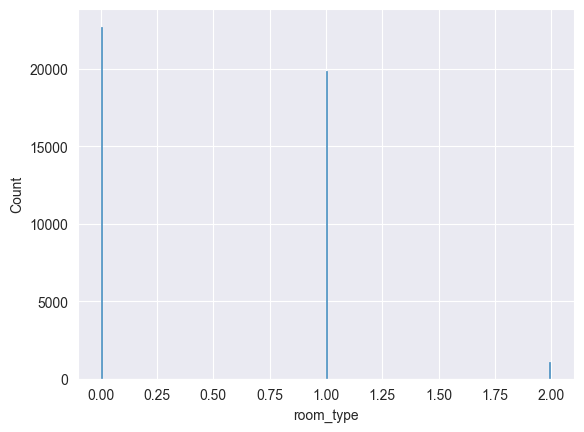

In [221]:
    sns.histplot(data=data, x='room_type', bins=220)
    #     hue="diagnosis",
    #     bins=50,
    #     kde=True,
    #     element="step",
    #     stat="density",
    #     ax=ax
    # )

In [206]:
# # Посмотрим на хитмап корреляции фичей в их влиянии на целевую функцию, с помощью seaborn
# import seaborn as sns
#
# plt.figure(figsize=(10, 10))
# sns.heatmap(data.drop(['category'], axis=1).corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
# plt.show()

In [226]:
# Обучение классификатора, который предсказывает Категорию жилья

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Свой Scaler который возвращает типы Pandas
from sklearn.preprocessing import StandardScaler
class StandardScalerPd(StandardScaler):
    def transform(self, X, *args, **kwargs):
        X_scaled = super().transform(X, *args, **kwargs)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    def fit_transform(self, X, *args, **kwargs):
        X_scaled = super().fit_transform(X, *args, **kwargs)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

#------------------------------------------------------------------------------------------

# Разбиваем датасет на train и test, со стратификацией. Готовим датасеты для Классификатор и для Регрессора
X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['category'],
    test_size=0.30,
    random_state=42,
    stratify=data['category']
)

# Сохраняем Price и Category отдельно перед скейлингом
train_Price = X_train['price']
test_Price = X_test['price']
train_Category = X_train['category']
test_Category = X_test['category']
X_train = X_train.drop(columns=['price', 'category'])
X_test = X_test.drop(columns=['price', 'category'])

# Приводим значения признаков к одному масштабу
scaler = StandardScalerPd()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Готовим датасет для обучения Классификатора
X_train_Classifier = X_train
X_test_Classifier = X_test
y_train_Classifier = y_train
y_test_Classifier = y_test

# Learning Classifier из коробки
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_Classifier, y_train_Classifier)

# print("Из коробки k - n_neighbors: {}".format(model.n_neighbors))
# print("Из коробки p - расстояние (норма): {}".format(model.p))

# Проверяем метрики модели на тестовой выборке
y_test_Classifier_Predictions = model.predict(X_test_Classifier)
# print("--------")
print("Resulting test score - accuracy_score: {:.3f}".format(accuracy_score(y_test_Classifier_Predictions, y_test_Classifier)))
print("Resulting test score - precision_score: {:.3f}".format(precision_score(y_test_Classifier_Predictions, y_test_Classifier)))
print("Resulting test score - recall_score: {:.3f}".format(recall_score(y_test_Classifier_Predictions, y_test_Classifier)))
print("Resulting test score - f1_score: {:.3f}".format(f1_score(y_test_Classifier_Predictions, y_test_Classifier)))

Resulting test score - accuracy_score: 0.931
Resulting test score - precision_score: 0.107
Resulting test score - recall_score: 0.466
Resulting test score - f1_score: 0.174


In [227]:
# Обучаем регрессор предсказывать цену на датасете, включающем Категорию жилья
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Готовим датасет для обучения Регрессора
# Добавляем Category без скейлинга, не критично, т.к. там значения 0 и 1 - не сильно отличаются по масштабу
X_train_Regressor = X_train.assign(category=train_Category)
X_test_Regressor1 = X_test.assign(category=test_Category)
X_test_Regressor2 = X_test.assign(category=y_test_Classifier_Predictions)
y_train_Regressor = train_Price
y_test_Regressor = test_Price

# Обучение из коробки
model = LGBMRegressor(random_state=42)
model.fit(X_train_Regressor, y_train_Regressor)
y_test_Regressor1_Predictions = model.predict(X_test_Regressor1)
y_test_Regressor2_Predictions = model.predict(X_test_Regressor2)

# Посчитаем RMSE
mask1 = test_Price < 100
mask2 = (test_Price < 500) & (test_Price >= 100)
mask3 = (test_Price < 1000) & (test_Price >= 500)
mask4 = test_Price >= 1000

rmse1 = np.sqrt(mean_squared_error(y_test_Regressor, y_test_Regressor1_Predictions))
rmse11 = (np.sqrt(mean_squared_error(y_test_Regressor[mask1], y_test_Regressor1_Predictions[mask1])) if len(y_test_Regressor[mask1]) > 0 else 0)
rmse12 = (np.sqrt(mean_squared_error(y_test_Regressor[mask2], y_test_Regressor1_Predictions[mask2])) if len(y_test_Regressor[mask2]) > 0 else 0)
rmse13 = (np.sqrt(mean_squared_error(y_test_Regressor[mask3], y_test_Regressor1_Predictions[mask3])) if len(y_test_Regressor[mask3]) > 0 else 0)
rmse14 = (np.sqrt(mean_squared_error(y_test_Regressor[mask4], y_test_Regressor1_Predictions[mask4])) if len(y_test_Regressor[mask4]) > 0 else 0)

rmse2 = np.sqrt(mean_squared_error(y_test_Regressor, y_test_Regressor2_Predictions))
rmse21 = (np.sqrt(mean_squared_error(y_test_Regressor[mask1], y_test_Regressor2_Predictions[mask1])) if len(y_test_Regressor[mask1]) > 0 else 0)
rmse22 = (np.sqrt(mean_squared_error(y_test_Regressor[mask2], y_test_Regressor2_Predictions[mask2])) if len(y_test_Regressor[mask2]) > 0 else 0)
rmse23 = (np.sqrt(mean_squared_error(y_test_Regressor[mask3], y_test_Regressor2_Predictions[mask3])) if len(y_test_Regressor[mask3]) > 0 else 0)
rmse24 = (np.sqrt(mean_squared_error(y_test_Regressor[mask4], y_test_Regressor2_Predictions[mask4])) if len(y_test_Regressor[mask4]) > 0 else 0)

print('------------------------------------------------------------')
print("RMSE 1 (на рассчитанных значениях Category):", rmse1)
print("RMSE 11 (в ценовом диапазоне до 100 USD):", rmse11)
print("RMSE 12 (в ценовом диапазоне от 100 до 500 USD):", rmse12)
print("RMSE 13 (в ценовом диапазоне от 500 до 1000 USD):", rmse13)
print("RMSE 14 (в ценовом диапазоне от 1000 USD):", rmse14)
print('------------------------------------------------------------')
print("RMSE 2 (на предсказанных значениях Category):", rmse2)
print("RMSE 21 (в ценовом диапазоне до 100 USD):", rmse21)
print("RMSE 22 (в ценовом диапазоне от 100 до 500 USD):", rmse22)
print("RMSE 23 (в ценовом диапазоне от 500 до 1000 USD):", rmse23)
print("RMSE 24 (в ценовом диапазоне от 1000 USD):", rmse24)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 30559, number of used features: 10
[LightGBM] [Info] Start training from score 140.057332
------------------------------------------------------------
RMSE 1 (на рассчитанных значениях Category): 142.4621145021821
RMSE 11 (в ценовом диапазоне до 100 USD): 58.016325041437234
RMSE 12 (в ценовом диапазоне от 100 до 500 USD): 83.78977700448456
RMSE 13 (в ценовом диапазоне от 500 до 1000 USD): 292.55201043806676
RMSE 14 (в ценовом диапазоне от 1000 USD): 1640.1103796465131
------------------------------------------------------------
RMSE 2 (на предсказанных значениях Category): 177.207954243558
RMSE 21 (в ценовом диапазоне до 100 USD): 49.86034722758947
RMSE 22 (в ценовом диапаз